In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

%matplotlib notebook

In [13]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(50, 100, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(100, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(150, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(200, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(250, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/5000.0]*5000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(x, fs) for x in d[5:9]] + [button])
    
    

In [14]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    
    en = np.array(np.where(xt == -1))[0]
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(4):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [15]:
files = ["flex.txt", "ext.txt", "clk.txt", "cclk.txt"]
read_dat = [readFile(_) for _ in files]
feats = [extract_feat(_, feat) for _ in read_dat]

Reading: flex.txt
Reading: ext.txt
Reading: clk.txt
Reading: cclk.txt
37 37
53 53
43 43
45 45


In [16]:
for i in feats:
    print(len(i), i[0])

37 [164.85433943  83.90513317 110.87072807 453.54259009]
53 [ 78.51206682  87.84230332  75.49913281 104.12085151]
43 [62.12560632 68.46977767 74.55769334 69.24303544]
45 [ 66.20664844  58.92485425  54.9860552  178.35342451]


<IPython.core.display.Javascript object>


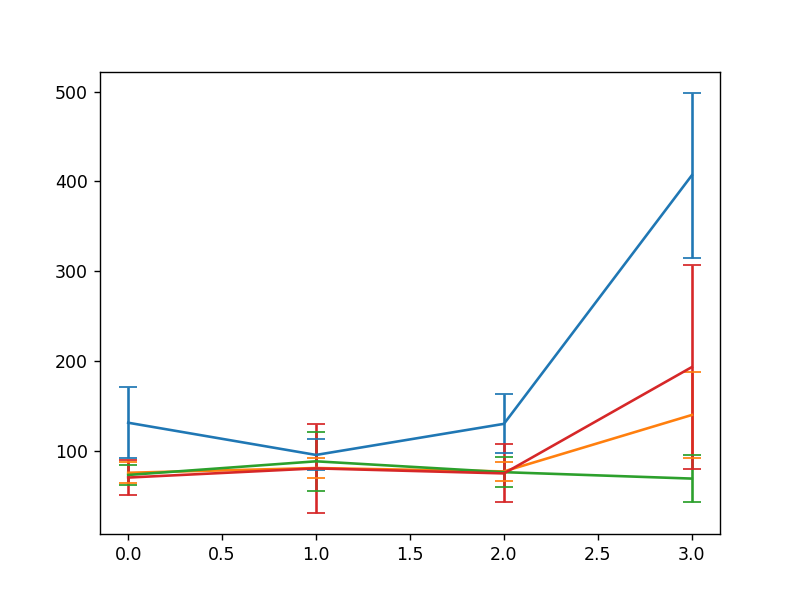

In [17]:
plt.figure()

colors = ["green", "red", "yellow", "blue", "orange"]

for ci,fe in enumerate(feats):
    fe = fe.swapaxes(0,1)
    #print(np.mean(fe, 1), np.std(fe, 1))
    plt.errorbar(range(4), np.mean(fe, 1), np.std(fe, 1), capsize=5)
    
    #for i in range(len(fe)):
    #    plt.plot(range(6), fe[i], "*", color = colors[ci])

plt.show()

In [18]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [19]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [20]:
dat = []
for chn in range(1, 5):
    tdat = []
    for chs in list(combinations([0,1,2,3], chn)):
        for chir in range(len(chs)):
            if len(chs) == 1: chir = None
            tdat.append([chs, chir, getAccuracy(*getXy(feats, chs, chir), r = 0.2)])
            print(tdat[-1])
    dat.append(tdat)

[(0,), None, (71.78169014084509, 46.925)]
[(1,), None, (66.15140845070421, 33.638888888888886)]
[(2,), None, (74.68591549295775, 44.4)]
[(3,), None, (93.84718309859154, 39.74444444444445)]
[(0, 1), 0, (43.66056338028169, 41.169444444444444)]
[(0, 1), 1, (41.3507042253521, 38.51388888888889)]
[(0, 2), 0, (30.219014084507045, 28.052777777777777)]
[(0, 2), 1, (29.96549295774648, 28.266666666666666)]
[(0, 3), 0, (63.44859154929577, 58.4)]
[(0, 3), 1, (62.118309859154934, 57.416666666666664)]
[(1, 2), 0, (43.96338028169014, 41.70277777777778)]
[(1, 2), 1, (45.59859154929577, 43.1)]
[(1, 3), 0, (69.01197183098591, 67.62222222222222)]
[(1, 3), 1, (65.80492957746479, 63.48888888888889)]
[(2, 3), 0, (63.71830985915493, 60.086111111111116)]
[(2, 3), 1, (59.916197183098596, 55.83611111111111)]
[(0, 1, 2), 0, (43.95492957746479, 41.27777777777777)]
[(0, 1, 2), 1, (44.25281690140845, 41.7)]
[(0, 1, 2), 2, (45.55633802816901, 42.230555555555554)]
[(0, 1, 3), 0, (68.50140845070423, 64.97222222222221)

In [21]:
Xx, Yy = [], []
M_X = []
for ci, i in enumerate(dat):
    MxX, MxV = None, None
    for j in i:
        Xx.append(ci+1)
        Yy.append(j[2][1])
        if MxV is None or MxV < j[2][1]:
            MxV = j[2][1]
            MxX = j
    M_X.append(MxX[2][1])
    print(MxX)
print(M_X)

[(0,), None, (71.78169014084509, 46.925)]
[(1, 3), 0, (69.01197183098591, 67.62222222222222)]
[(1, 2, 3), 0, (69.82464788732395, 67.78333333333335)]
[(0, 1, 2, 3), 1, (70.10492957746479, 67.91944444444444)]
[46.925, 67.62222222222222, 67.78333333333335, 67.91944444444444]


In [23]:
M_X, Xx, Yy

([46.925, 67.62222222222222, 67.78333333333335, 67.91944444444444],
 [1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4],
 [46.925,
  33.638888888888886,
  44.4,
  39.74444444444445,
  41.169444444444444,
  38.51388888888889,
  28.052777777777777,
  28.266666666666666,
  58.4,
  57.416666666666664,
  41.70277777777778,
  43.1,
  67.62222222222222,
  63.48888888888889,
  60.086111111111116,
  55.83611111111111,
  41.27777777777777,
  41.7,
  42.230555555555554,
  64.97222222222221,
  67.71388888888887,
  61.73055555555556,
  59.63055555555555,
  61.84166666666666,
  56.330555555555556,
  67.78333333333335,
  66.38888888888889,
  60.15277777777778,
  64.025,
  67.91944444444444,
  66.35277777777777,
  58.991666666666674])

<IPython.core.display.Javascript object>


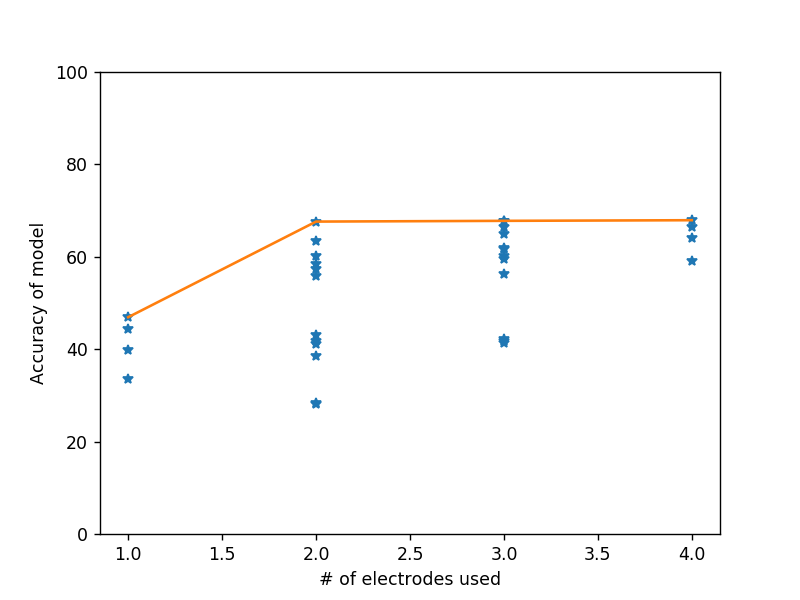

In [22]:
plt.figure()
plt.plot(Xx, Yy, "*")
plt.plot(range(1,5), M_X, "-")
plt.xlabel("# of electrodes used")
plt.ylabel("Accuracy of model")
plt.ylim([0,100])
plt.show()